In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt

UsageError: Line magic function `%` not found.


In [ ]:
# S&P500 dataframe: list of tickers
sp_df = pd.read_html('https://wikipedia.org/wiki/List_of_S%26P_500_companies', flavor='html5lib')[0]
sp_df

/var/folders/21/rvw9mkxn5jz8cstyz4tllyhr0000gn/T/ipykernel_10551/625079946.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sp_df['Symbol'] = sp_df['Symbol'].str.replace('.', '-')


[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed
[*****

<Axes: title={'center': 'S&P500, 1yr High/Low count: absolute & relative series'}, xlabel='Date'>

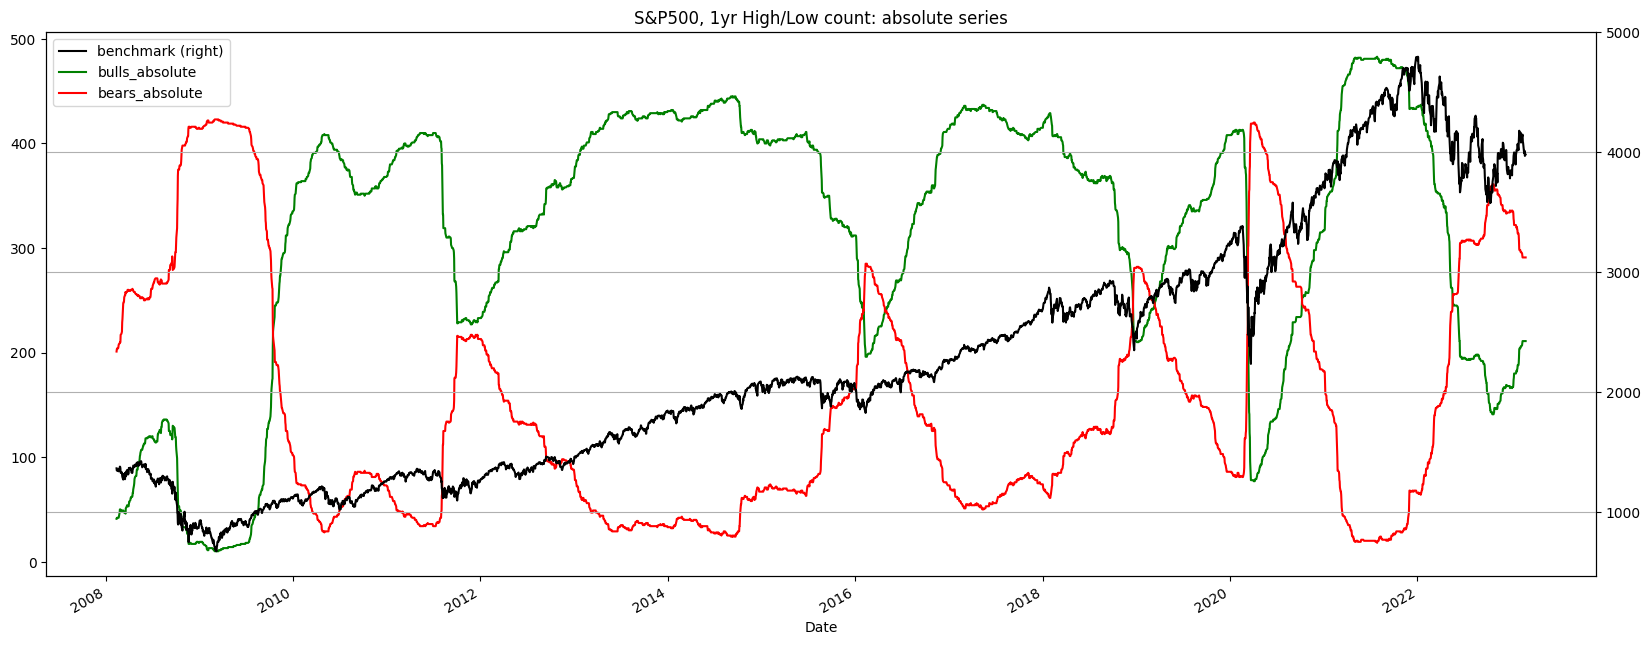

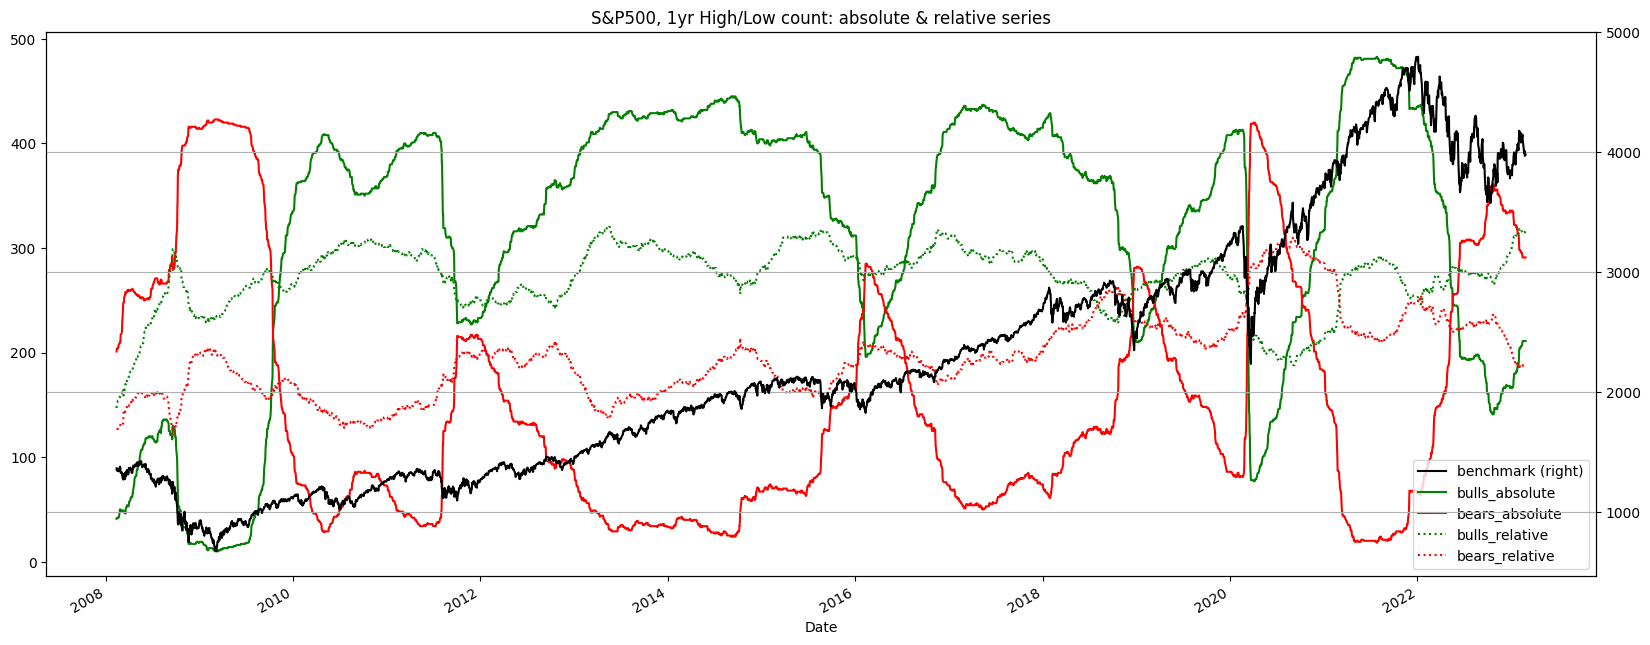

In [15]:
sp_df['Symbol'] = sp_df['Symbol'].str.replace('.', '-')
bm_ticker = '^GSPC'
tickers_list = [bm_ticker] + list(sp_df['Symbol'])[:]

# Variables instantiation
window = 252
show_batch = True
df_abs = pd.DataFrame()
batch_size = 20
loop_size = int(len(tickers_list) // batch_size) + 2

# Batch download
for t in range(1, loop_size):
    m = (t - 1) * batch_size
    n = t * batch_size
    batch_list = tickers_list[m:n]

    batch_download = \
    yf.download(tickers=batch_list, start='2007-01-01', end=None, interval='1d', group_by='column', auto_adjust=True,
                prepost=True, proxy=False)['Close']

    df_abs = df_abs.join(batch_download, how='outer')

bullbear = pd.DataFrame()
bullbear['benchmark'] = round(df_abs[bm_ticker].copy(), 2)

df_rel = round(df_abs.divide(df_abs[bm_ticker], axis=0).mul(df_abs[bm_ticker][0]), 1)
df_rel = pd.DataFrame(data=np.where(df_rel >= df_rel.rolling(window).max(), 1,
                                    np.where(df_rel <= df_rel.rolling(window).min(), -1, np.nan)),
                      index=df_rel.index, columns=df_rel.columns).fillna(method='ffill')

df_abs = pd.DataFrame(data=np.where(df_abs >= df_abs.rolling(window).max(), 1,
                                    np.where(df_abs <= df_abs.rolling(window).min(), -1, np.nan)),
                      index=df_abs.index, columns=df_abs.columns).fillna(method='ffill')

bullbear['bulls_absolute'] = df_abs[df_abs > 0].count(axis=1)
bullbear['bears_absolute'] = df_abs[df_abs < 0].count(axis=1)
bullbear['bulls_relative'] = df_rel[df_rel > 0].count(axis=1)
bullbear['bears_relative'] = df_rel[df_rel < 0].count(axis=1)

bullbear[280:][['benchmark', 'bulls_absolute', 'bears_absolute',
                ]].plot(figsize=(20, 8),
                        style=['k', 'g', 'r'], grid=True, secondary_y=['benchmark'],
                        title='S&P500, 1yr High/Low count: absolute series')

bullbear[280:][['benchmark', 'bulls_absolute', 'bears_absolute', 'bulls_relative', 'bears_relative']].plot(
    figsize=(20, 8),
    style=['k', 'g', 'r', 'g:', 'r:'], grid=True, secondary_y=['benchmark'],
    title='S&P500, 1yr High/Low count: absolute & relative series')